# Práctica Final: Clasificación con Scikit-learn y MLflow

En esta práctica, utilizarás un conjunto de datos de Scikit-learn (podeís usar el mismo que en el notebook de Intro MLFlow) para entrenar un modelo de clasificación.

Pasos a seguir: 

    Exploración de Datos: Analiza el conjunto de datos proporcionado para comprender su estructura y contenido.

    Preprocesamiento de Texto: Realiza tareas de preprocesamiento de texto, como tokenización y vectorización, para preparar los datos para el modelado.

    Entrenamiento del Modelo: Utiliza algoritmos de clasificación de Scikit-learn para entrenar un modelo con los datos preprocesados.

    Evaluación del Modelo: Evalúa el rendimiento del modelo utilizando métricas de evaluación estándar como precisión y recall.

    Registro de Métricas con MLflow: Utiliza MLflow para registrar métricas y hiperparámetros durante el entrenamiento, facilitando la gestión y comparación de experimentos.


Nota: Dado que no voy a poder tener acceso a vuestros logs de MLFlow añadirme las imagenes de la interfaz de MLFlow en el notebook

In [12]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target



# En el target queremos adivinar el tipo de flor de iris: 

Clases en target:

0 → Iris Setosa

1 → Iris Versicolour

2 → Iris Virginica

In [14]:
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [15]:
df.describe()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [24]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

# Dividimos el df en train y test 
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["target"])
test_target = test["target"]
test[["target"]].to_csv("test-target.csv", index=False)
test.drop(columns=["target"]).to_csv("test.csv", index=False)

# Separamos la variable a clasificar del resto
features = [col for col in df.columns if col != "target"]
X = train[features]
y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Defino la lista de hiperparámetros
n_estimators_list = [10, 50, 100, 200]
learning_rates = [0.01, 0.1, 1]
max_depths = [3, 5, 7]

# Genero el entrenamiento con mlflow mediante un modelo xgboost
mlflow.set_experiment("Iris_XGBoost")

for n_estimators in n_estimators_list:
    for learning_rate in learning_rates:
        for max_depth in max_depths:
            with mlflow.start_run():
                # Prepocesamiento de datos
                preprocessor = Pipeline([("scaler", StandardScaler())])
                X_train_scaled = preprocessor.fit_transform(X_train)
                X_val_scaled = preprocessor.transform(X_val)

                model = XGBClassifier(n_estimators=n_estimators, 
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth, 
                                      random_state=42)
                model.fit(X_train_scaled, y_train)

                y_pred = model.predict(X_val_scaled)
                y_pred_proba = model.predict_proba(X_val_scaled)

                accuracy = accuracy_score(y_val, y_pred)
                f1 = f1_score(y_val, y_pred, average="weighted")
                logloss = log_loss(y_val, y_pred_proba)
                precision = precision_score(y_val, y_pred, average="weighted")
                recall = recall_score(y_val, y_pred, average="weighted")

                # Parámetros y métricas para analziar en mlflow
                mlflow.log_param("n_estimators", n_estimators)
                mlflow.log_param("learning_rate", learning_rate)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("f1_score", f1)
                mlflow.log_metric("log_loss", logloss)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)

                mlflow.xgboost.log_model(model, "xgboost_model")

c:\Users\rubgc\anaconda3\envs\bd14-despliegue-algo\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/02/23 11:17:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\rubgc\anaconda3\envs\bd14-despliegue-algo\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to cho

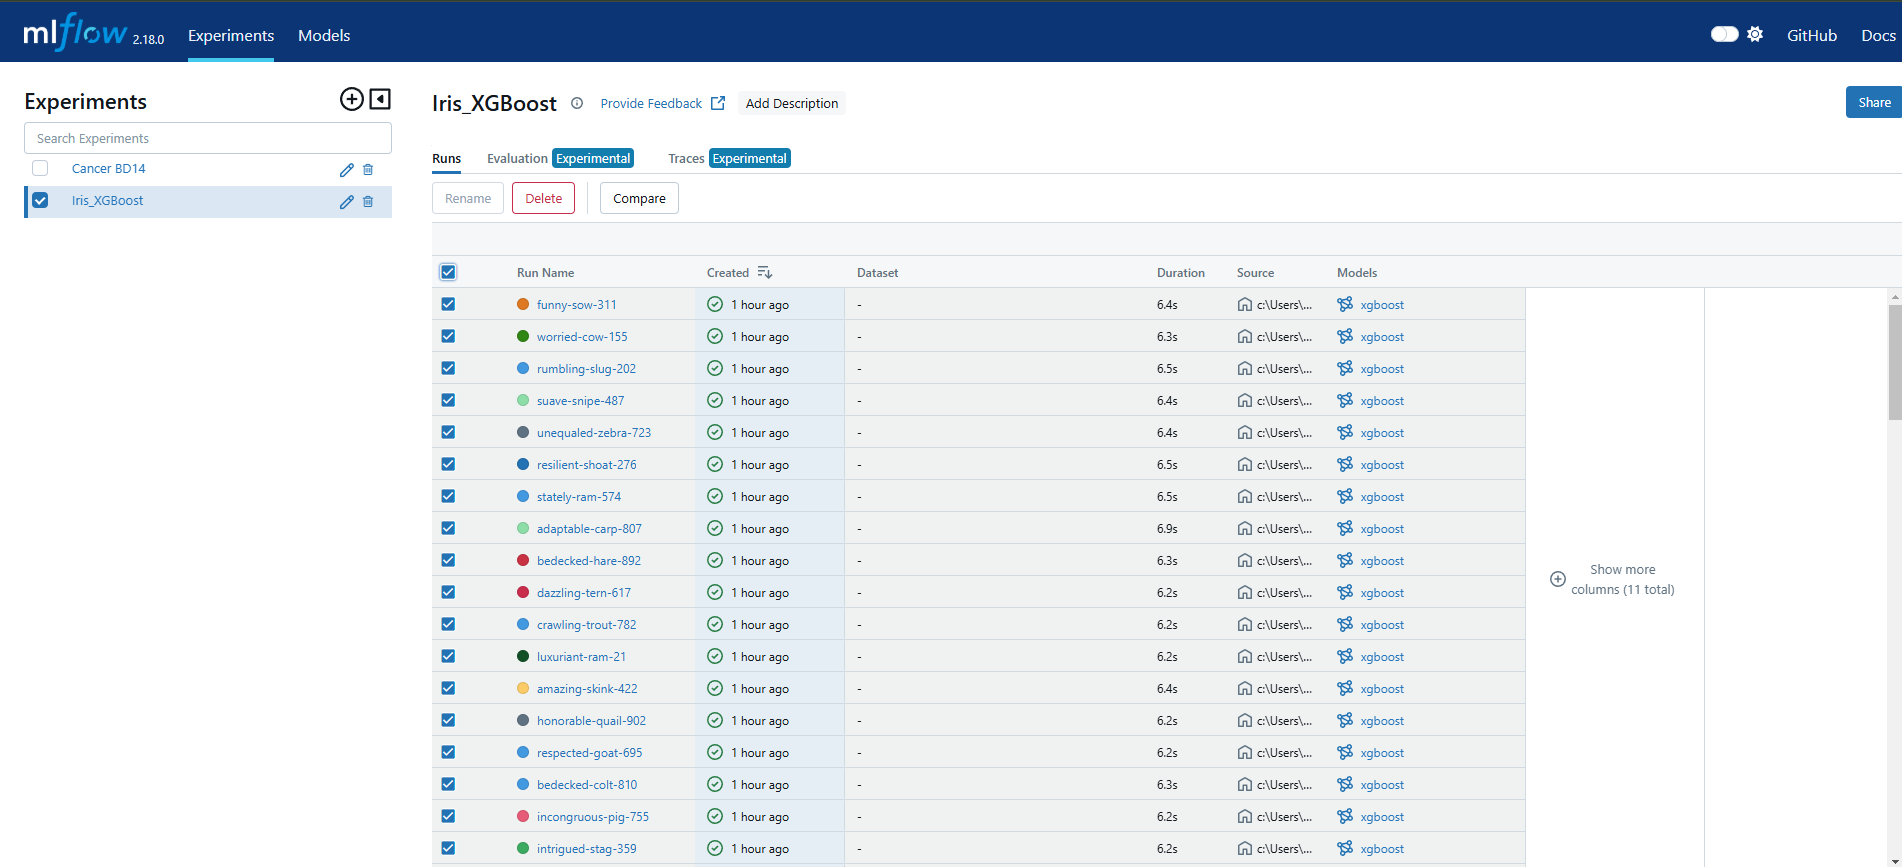

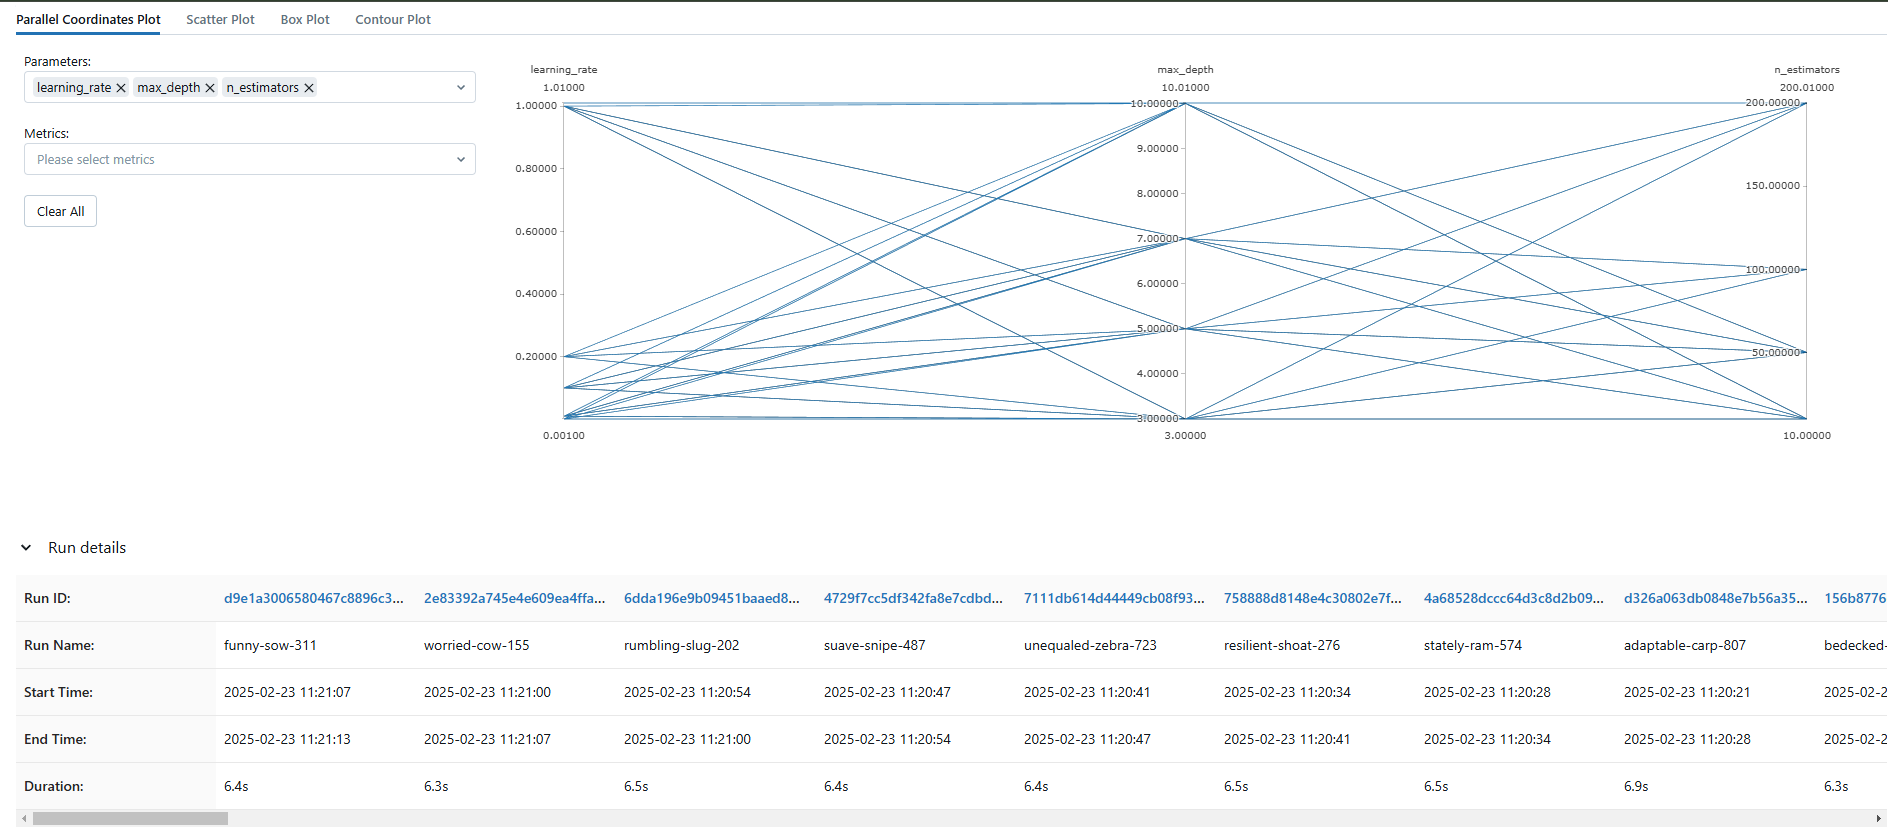

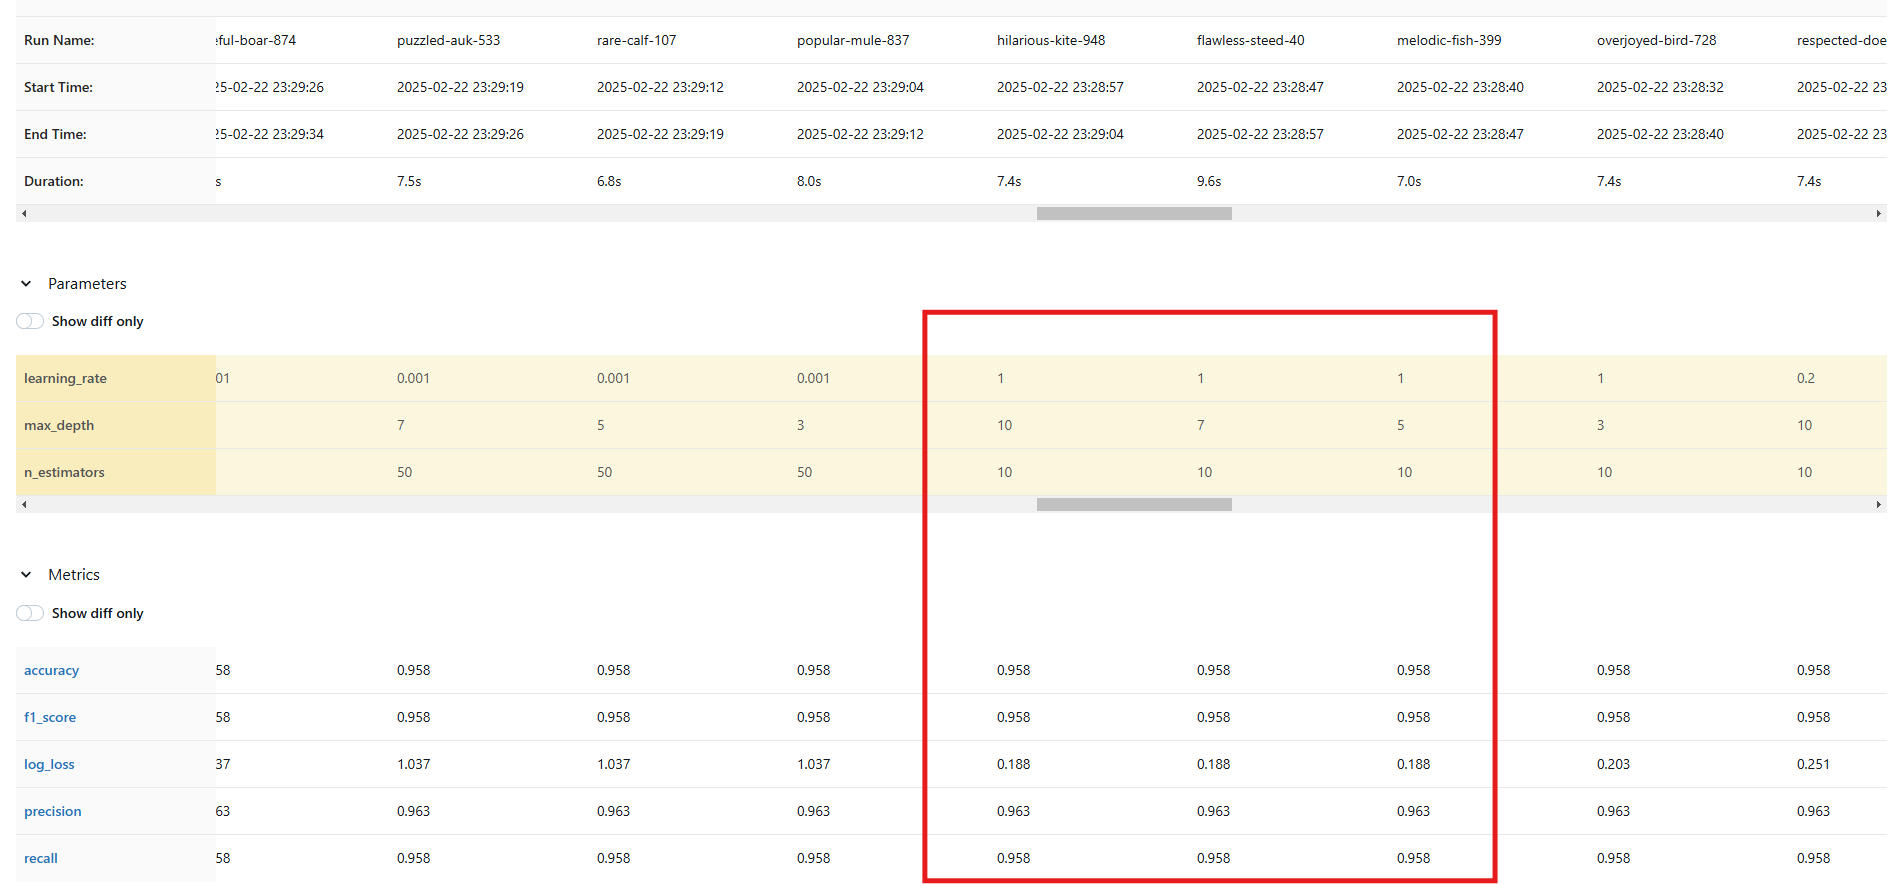

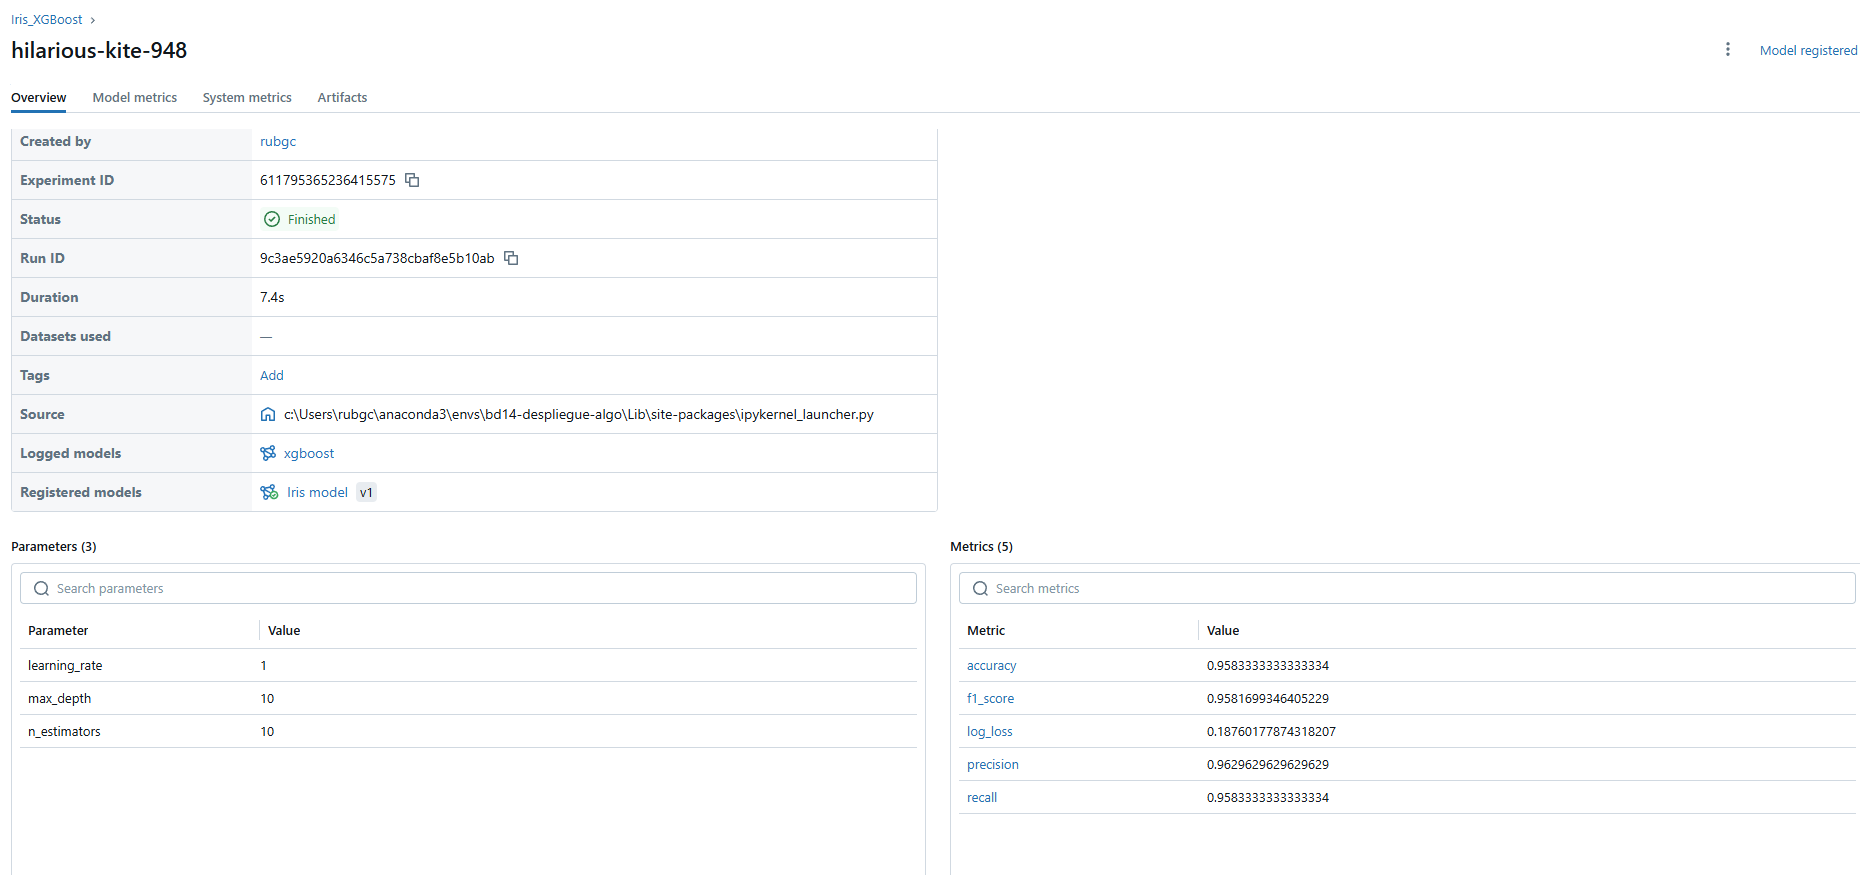

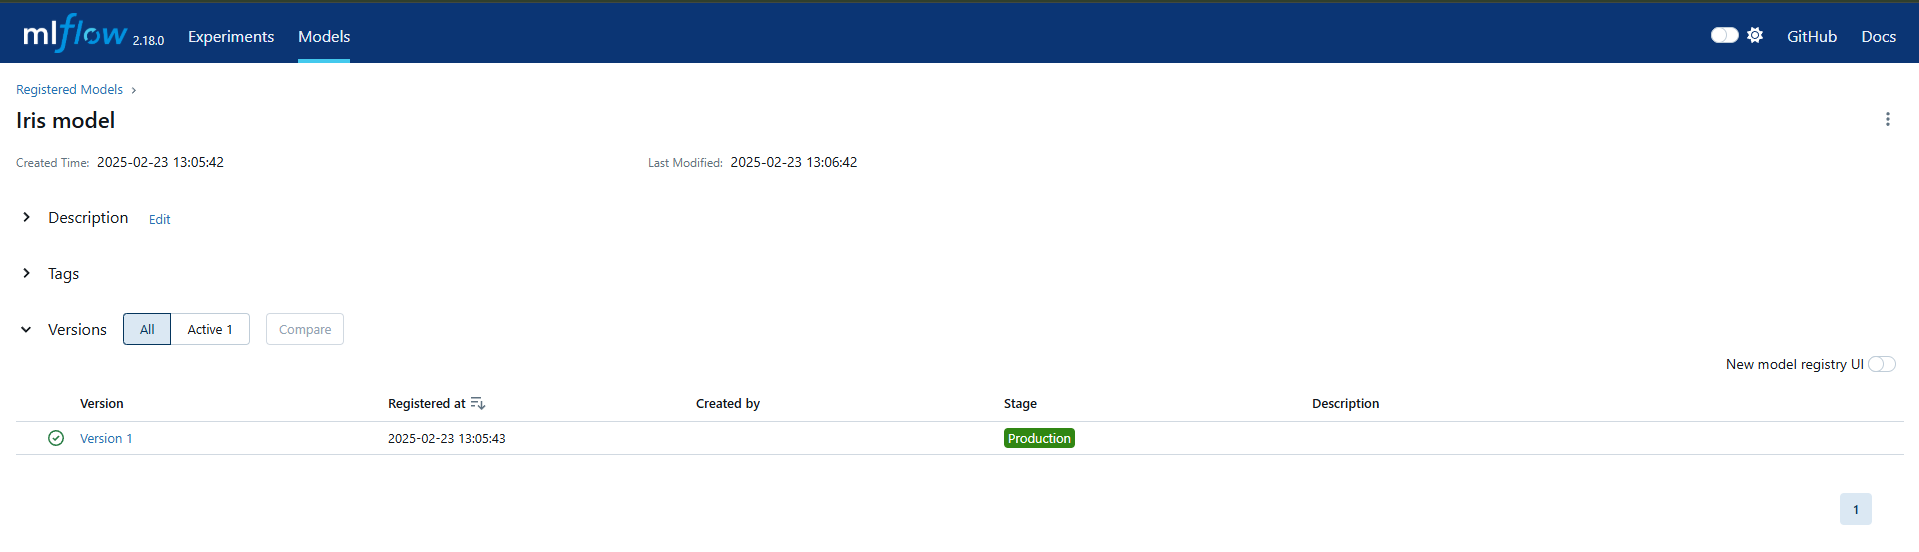

En este caso tenemos varios modelos que nos arrojan métricas muy similares, pero donde más diferencia vemos ens en el log_loss, por lo que vemos que con un learning rate de 1 es cuando obtenemos la mneor pérdida, por lo que es el modelo que llevamos a producción

## Generar .py de funciones y main con al menos dos argumentos de entrada.

In [26]:
%%writefile funciones_practica.py
import argparse
import time
import pandas as pd
import numpy as np
import mlflow
import mlflow.xgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, precision_score, recall_score
from sklearn.datasets import load_iris

def argumentos():
    parser = argparse.ArgumentParser(description='Ejecutar modelo XGBoost con MLflow tracking.')
    parser.add_argument('--nombre_job', type=str, help='Nombre del experimento en MLflow.', required=False, default="iris-xgboost-experiment")
    parser.add_argument('--n_estimators_list', nargs='+', type=int, help='Lista de valores para n_estimators.', required=True)
    return parser.parse_args()

def load_dataset():
    iris = load_iris()
    df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
    df['target'] = iris['target']
    return df

def data_treatment(df):
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

    test_target = test['target']
    test[['target']].to_csv('test-target.csv', index=False)
    test.drop(columns=['target']).to_csv('test.csv', index=False)

    features = [x for x in df.columns if x != 'target']
    x_train, x_test, y_train, y_test = train_test_split(train[features], train['target'],
                                                        test_size=0.2, random_state=42, stratify=train['target'])
    return x_train, x_test, y_train, y_test

def mlflow_tracking(nombre_job, x_train, x_test, y_train, y_test, n_estimators_list):
    time.sleep(5)
    mlflow.set_experiment(nombre_job)

    for n in n_estimators_list:
        with mlflow.start_run():
            clf = XGBClassifier(n_estimators=n, max_depth=3, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')

            preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
            model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            y_pred_proba = model.predict_proba(x_test)

            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            logloss = log_loss(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')

            mlflow.log_param('n_estimators', n)
            mlflow.log_metric('accuracy', accuracy)
            mlflow.log_metric('f1_score', f1)
            mlflow.log_metric('log_loss', logloss)
            mlflow.log_metric('precision', precision)
            mlflow.log_metric('recall', recall)
            mlflow.xgboost.log_model(clf, 'iris_xgboost_model')

    print("Entrenamiento y logging en MLflow finalizado correctamente.")

if __name__ == '__main__':
    args = argumentos()
    df = load_dataset()
    x_train, x_test, y_train, y_test = data_treatment(df)
    mlflow_tracking(args.nombre_job, x_train, x_test, y_train, y_test, args.n_estimators_list)


Overwriting funciones_practica.py


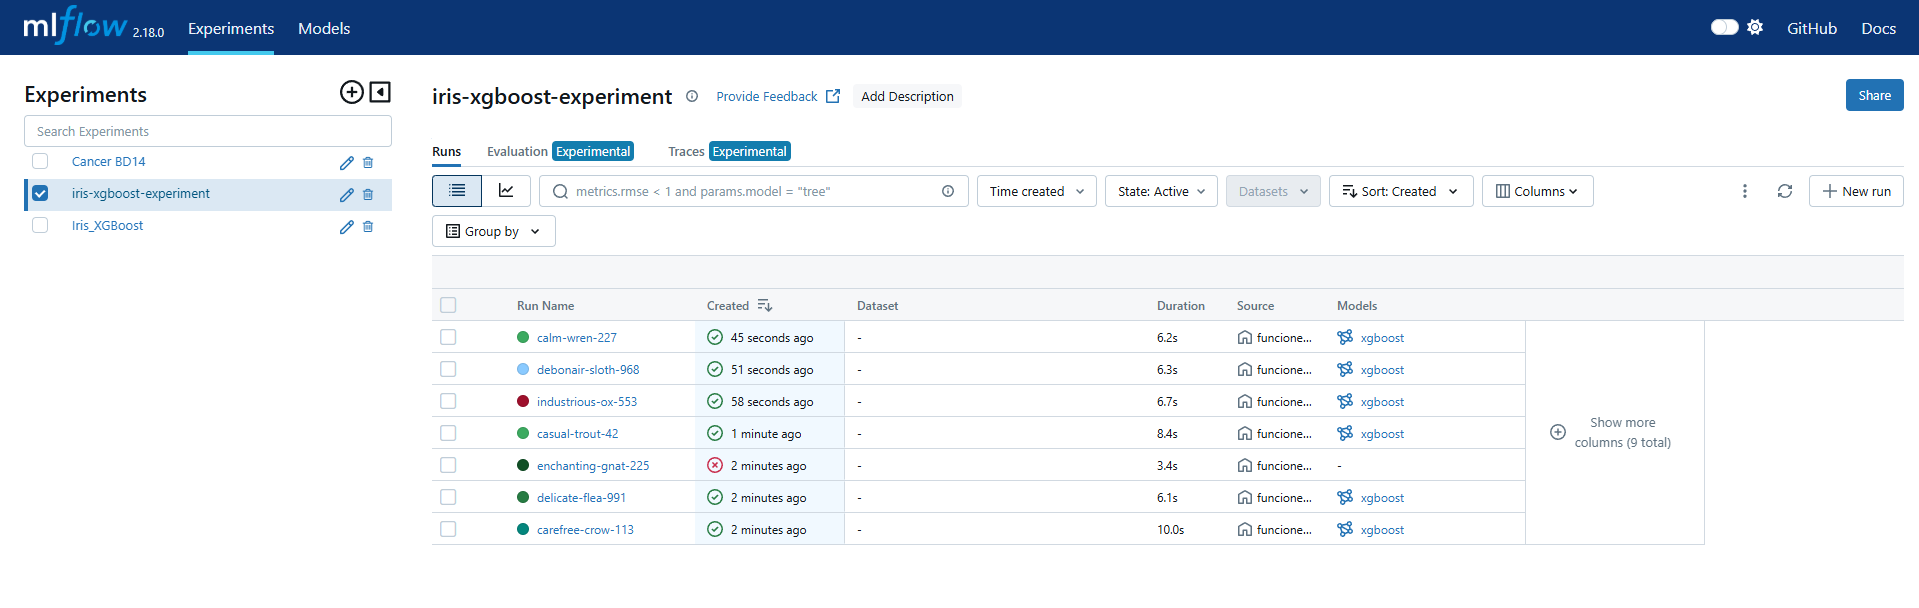

In [29]:
%%writefile main_practica.py
from fastapi import FastAPI, HTTPException
from transformers import pipeline

app = FastAPI()

# 1.Saludo
@app.get('/saluda')
def saluda(nombre: str, edad: int):
    return {'Message': f'Hola {nombre}, tienes {edad} años.'}

# 2.Operación matemática
@app.get('/operacion')
def operacion(num1: float, num2: float, operador: str):
    if operador == '+':
        resultado = num1 + num2
    elif operador == '-':
        resultado = num1 - num2
    elif operador == '*':
        resultado = num1 * num2
    elif operador == '/':
        if num2 == 0:
            raise HTTPException(status_code=400, detail="División por cero no permitida")
        resultado = num1 / num2
    else:
        raise HTTPException(status_code=400, detail="Operador no válido. Usa +, -, *, /")
    
    return {'Resultado': resultado}

# 3️.Análisis de sentimiento (HF)
@app.get('/sentiment')
def sentiment_classification(text: str, modelo: str = "distilbert-base-uncased-finetuned-sst-2-english"):
    sentiment_pipeline = pipeline('sentiment-analysis', model=modelo)
    resultado = sentiment_pipeline(text)[0]
    return {'Sentiment': resultado['label'], 'Confidence': resultado['score']}

# 4.Resumen de texto (HF)
@app.get('/resumen')
def resumen_texto(text: str, max_length: int = 50):
    summarizer = pipeline("summarization")
    resultado = summarizer(text, max_length=max_length, min_length=10, do_sample=False)
    return {'Resumen': resultado[0]['summary_text']}

# 5. Traducción español-inglés (HF)
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-es-en")

@app.get('/traducir')
def traducir(texto: str):
    try:
        resultado = translator(texto)[0]['translation_text']
        return {'Traducción': resultado}
    except Exception as e:
        return {'error': str(e)}


Overwriting main_practica.py


## Práctica parte FastAPI

### Para esta parte de la práctica teneis que generar un script con al menos 5 modulos app.get y dos de ellos tienen que ser pipelines de HF. 

### Parte de la practica se tendra que entregar en capturas de pantalla. Las capturas de pantalla a adjuntas son las siguientes. 

### 1. Captura de la pantalla docs con al menos 5 modulos. 
### 2. Captura de cada una de los modulos con la respuesta dentro de docs. 
### 3. Captura de cada uno de los modulos en la llamada https.
### 4. Todo el codigo usado durante el proceso. Notebooks y scripts.

### Opcional

### 5. Despliegue del script en GCP Cloud Run

# Resumen 5 módulos

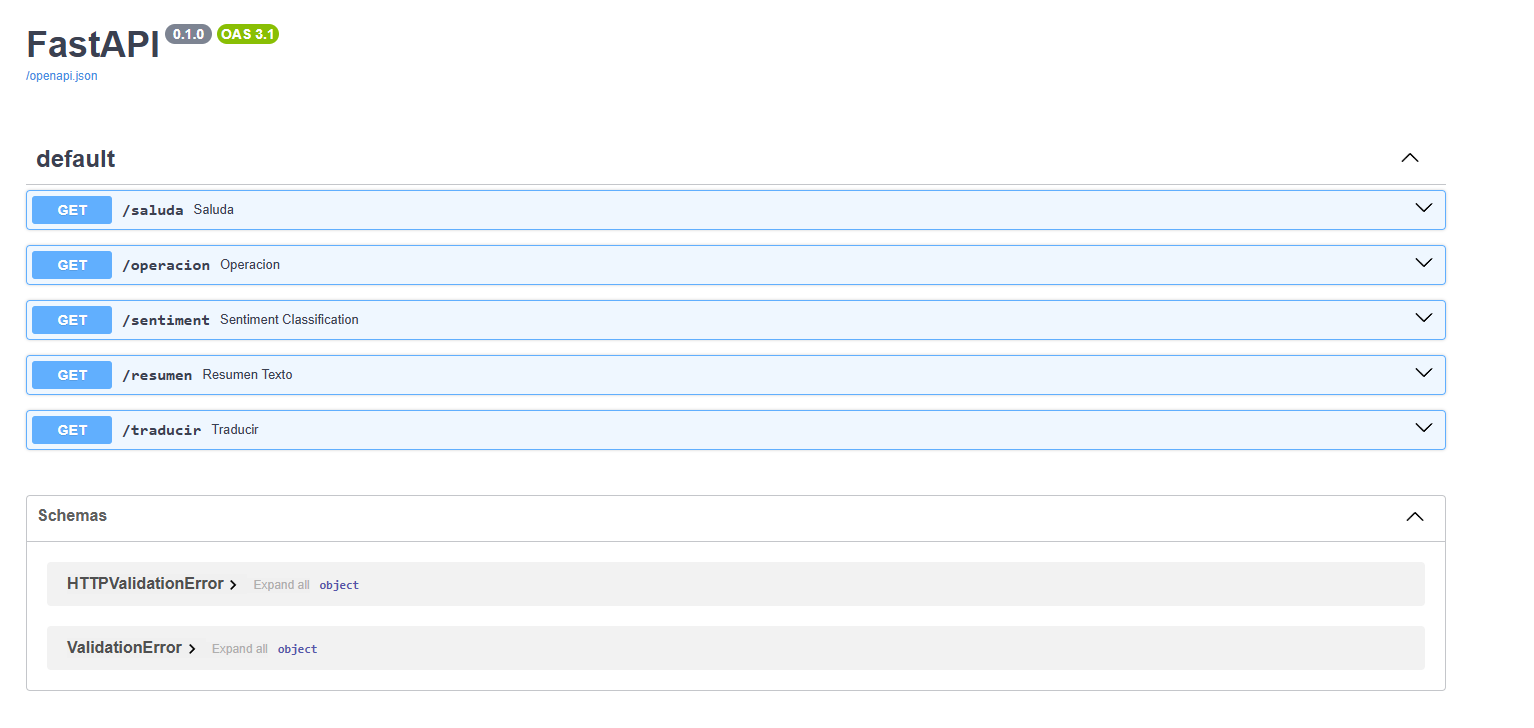

# Módulo 1

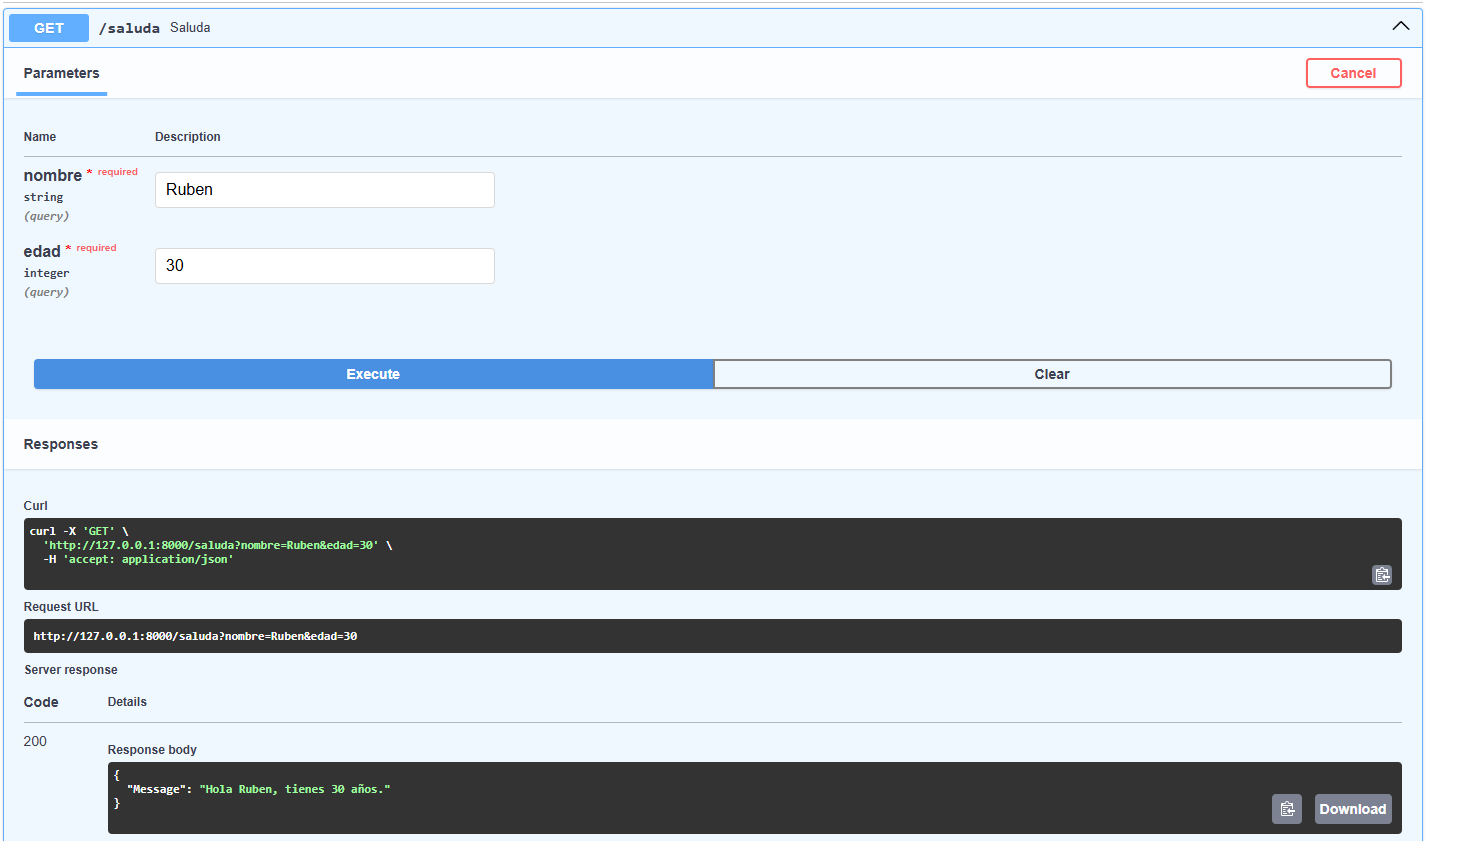

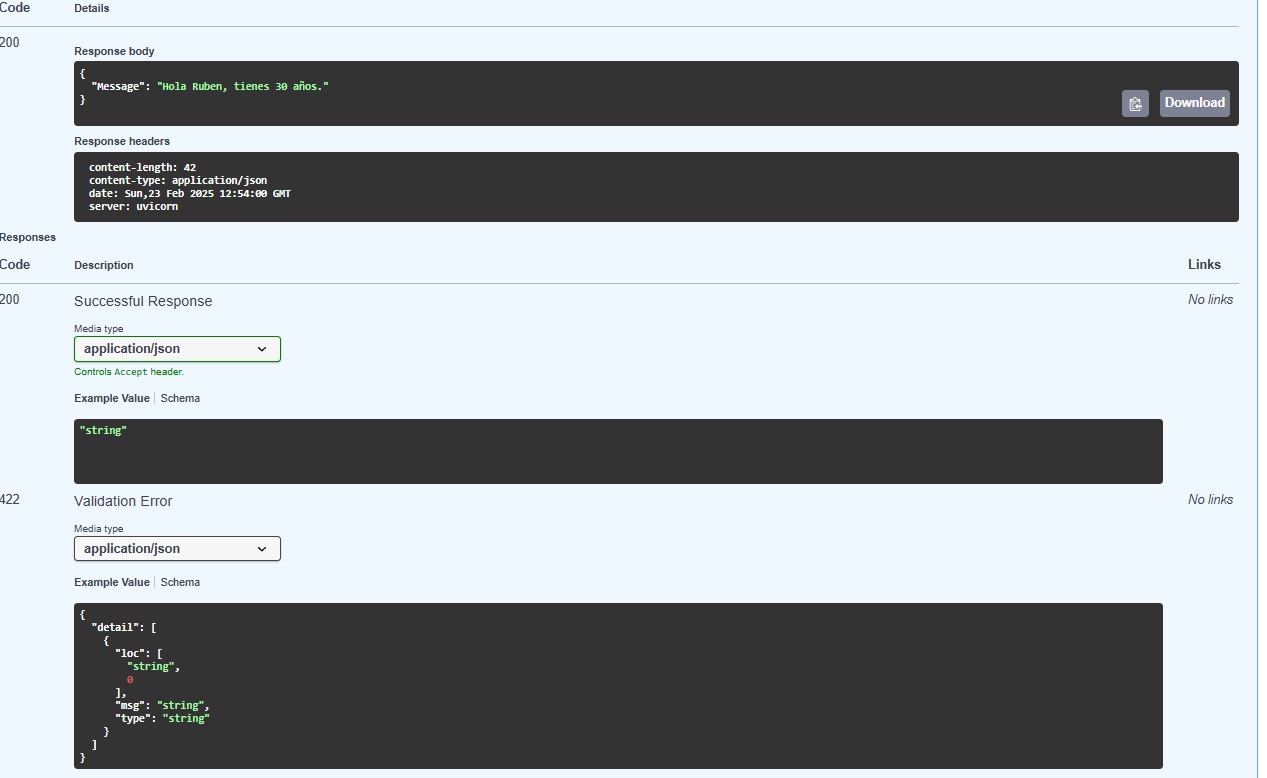

# Módulo 2

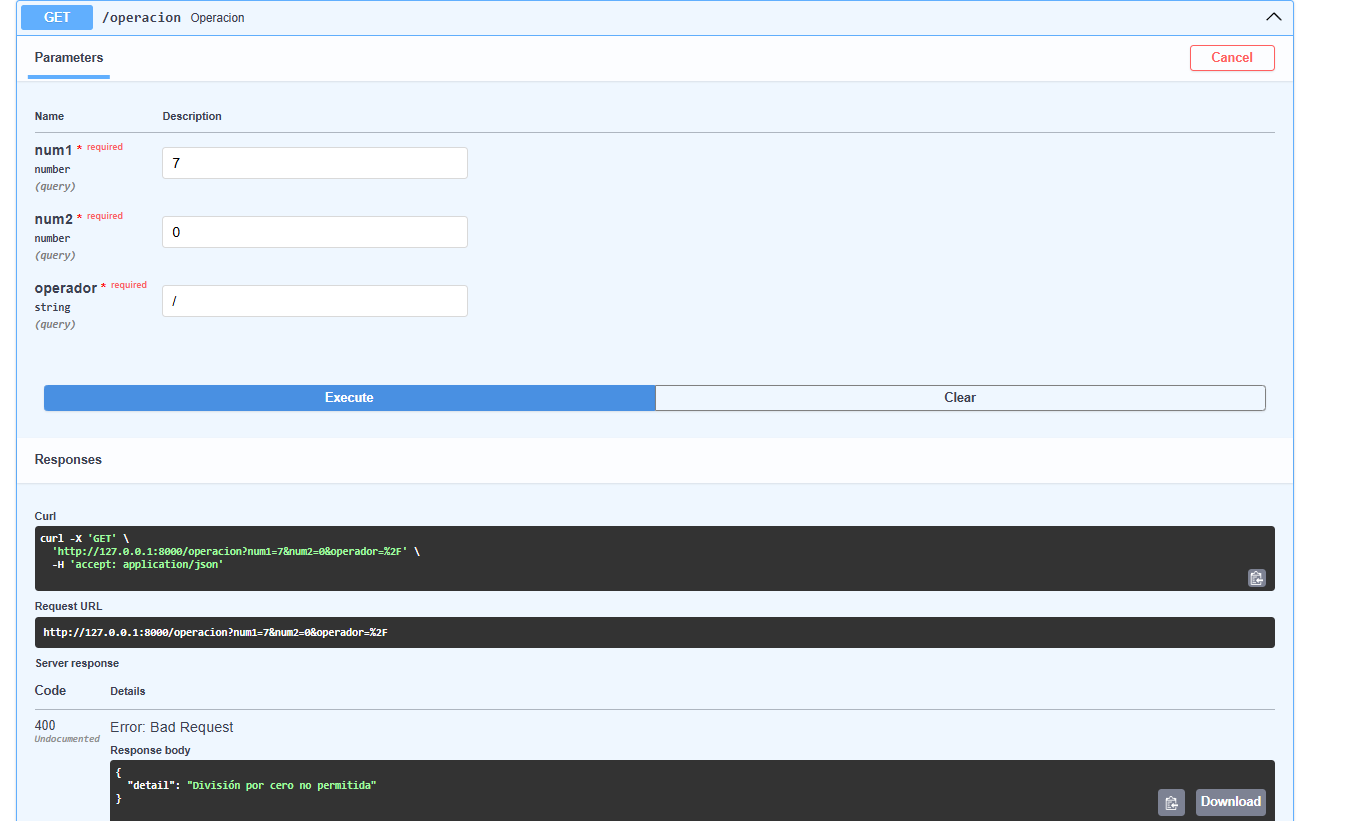

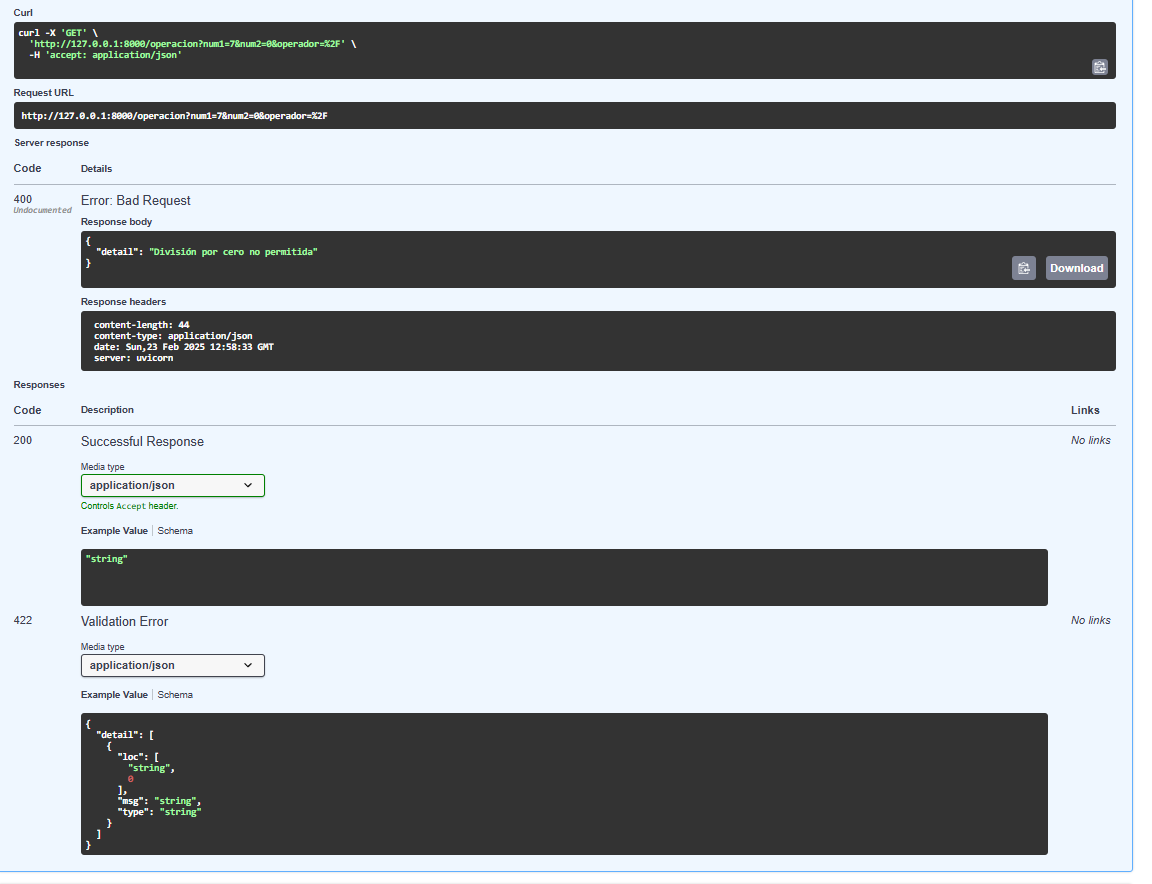

# Módulo 3

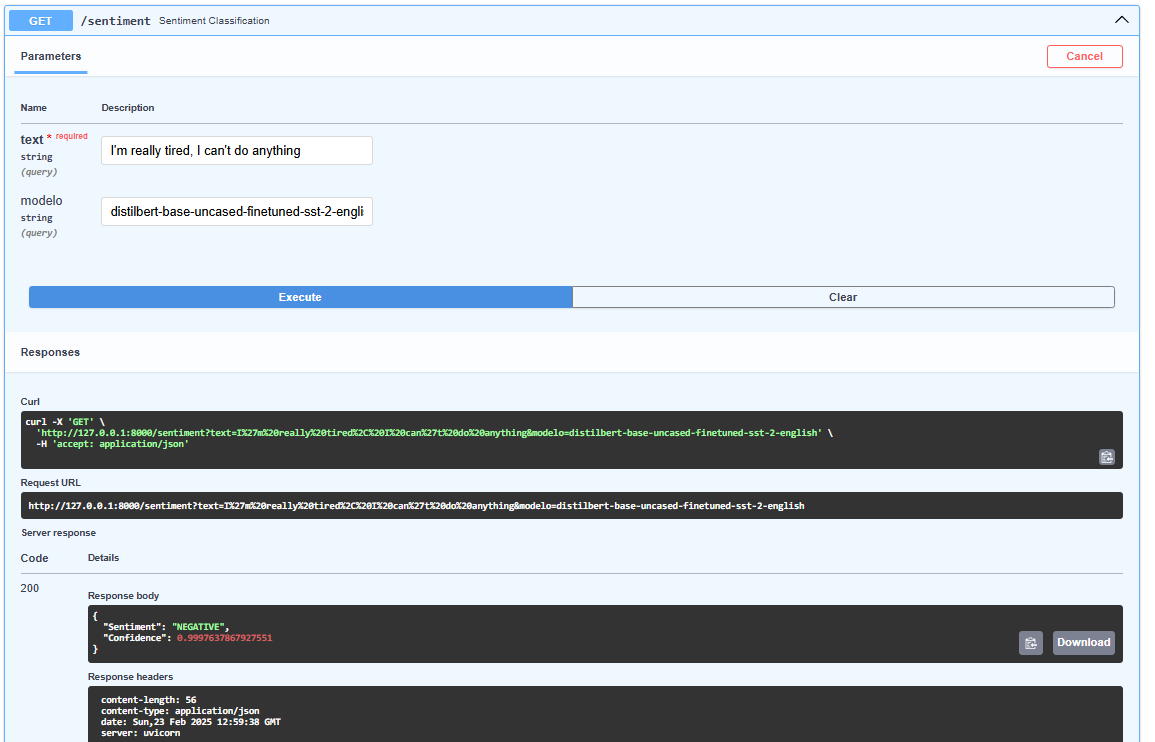

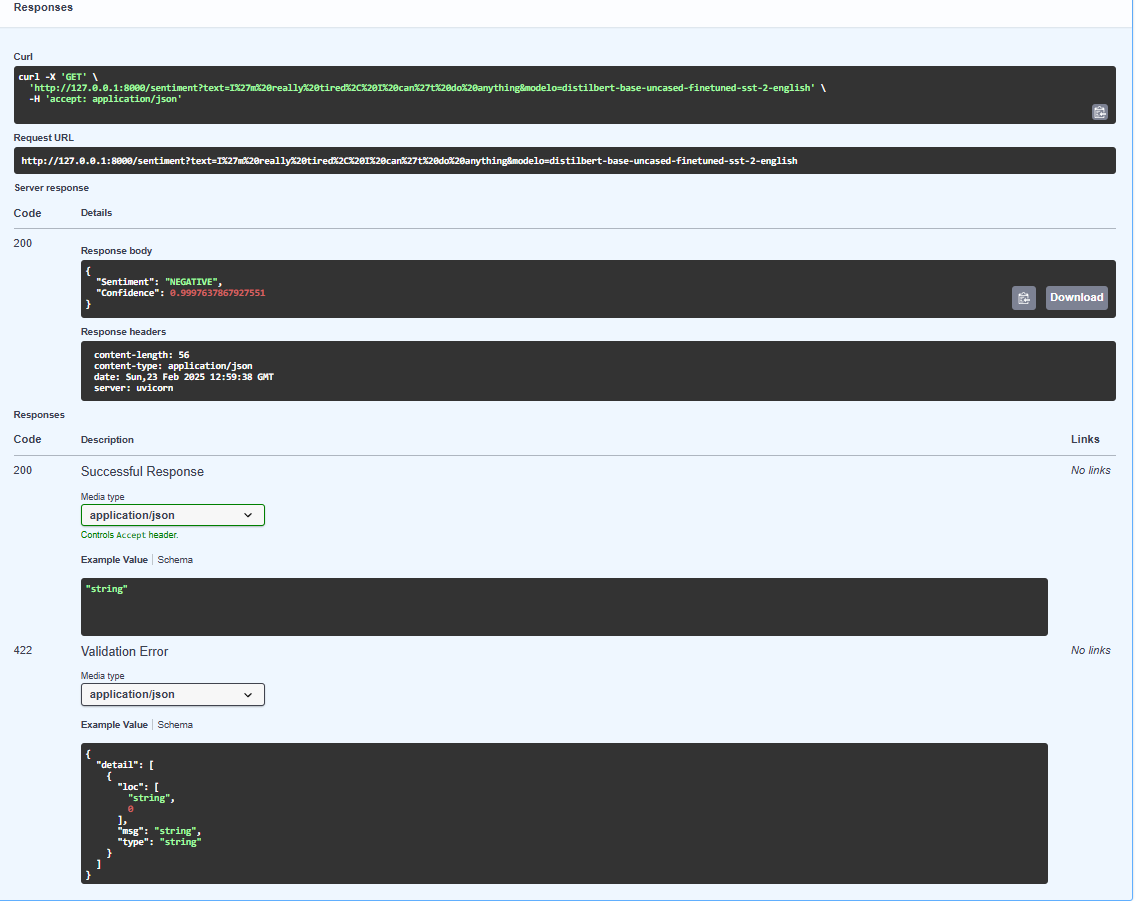

# Módulo 4

EL texto a resumir es el siguiente:

"Artificial Intelligence (AI) has transformed various industries, from healthcare to automotive. Recent advancements in deep learning and neural networks have enabled the creation of more efficient systems, capable of performing complex tasks that were once unthinkable for machines. Despite significant progress, challenges such as bias in models and the lack of interpretability of results still require attention. In the future, AI is expected to continue evolving and expand its applications further into fields such as education, entertainment, and scientific research."

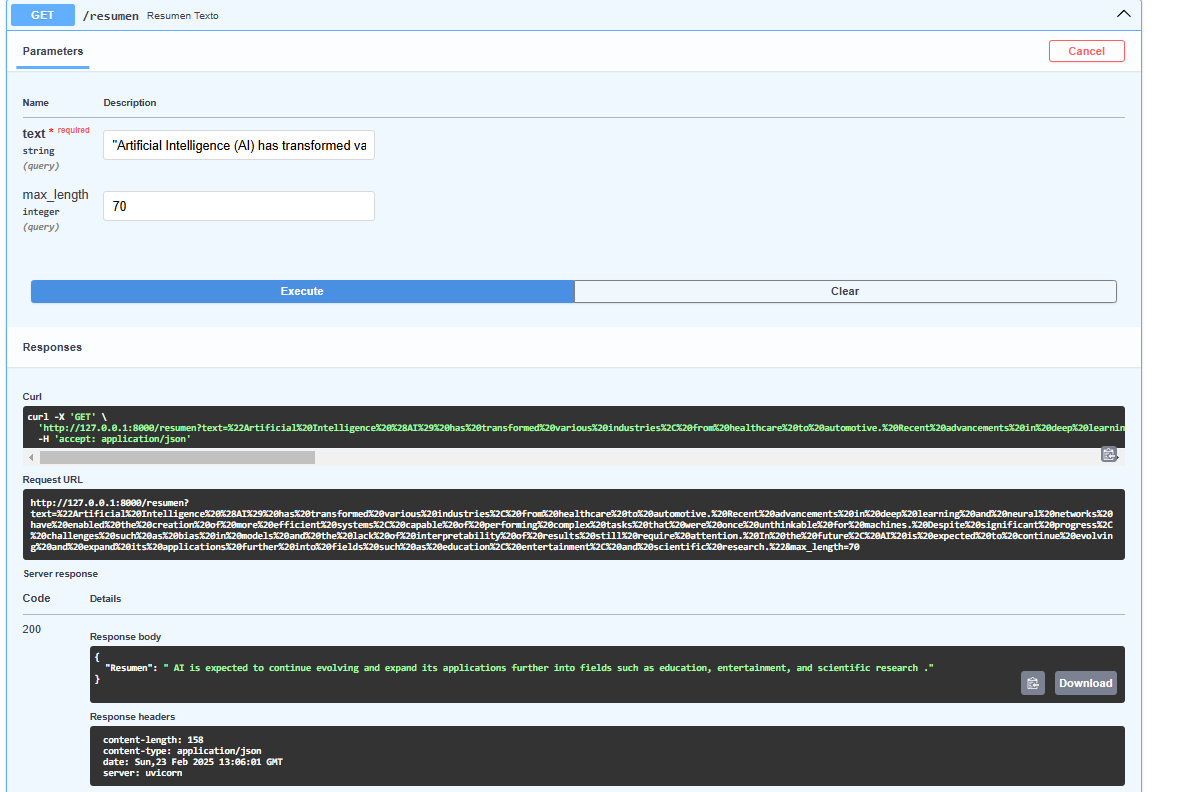

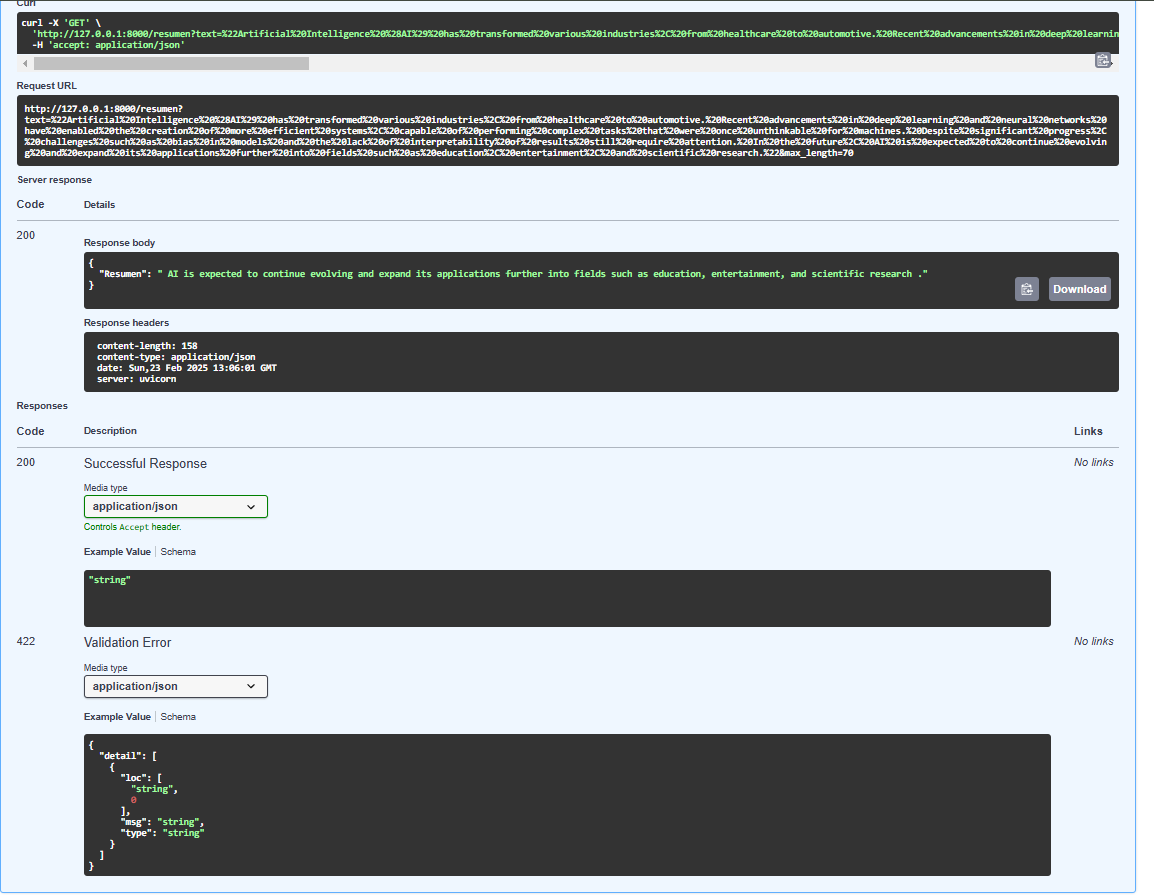

# Módulo 5

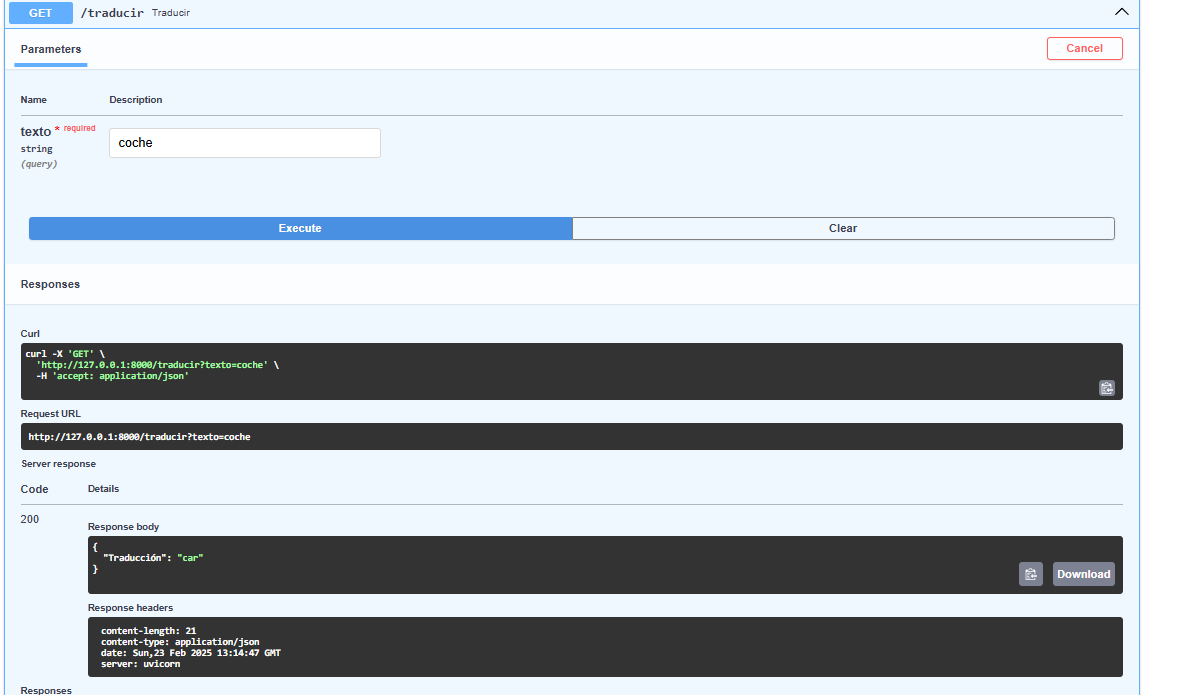

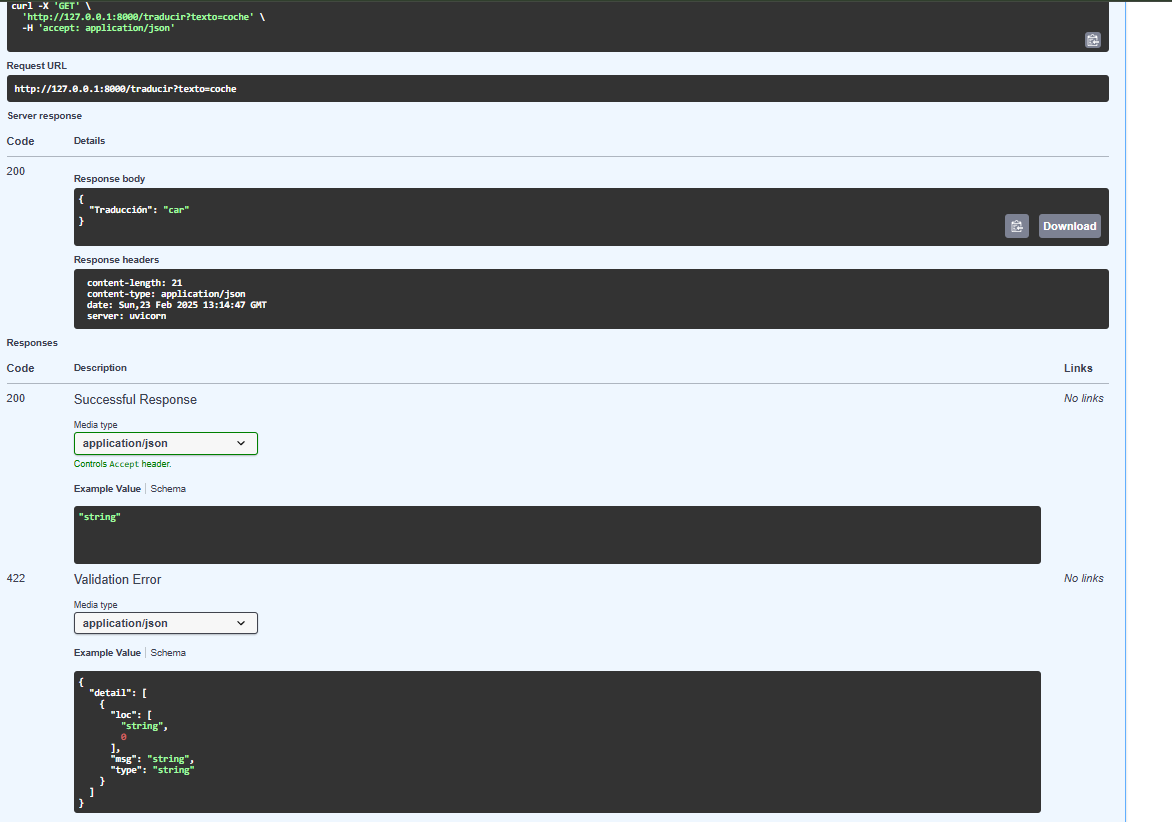